In [2]:
#hide
from utils import *
from fastai.vision.widgets import *

# From Model to Production

## The Practice of Deep Learning

### Starting Your Project

### The State of Deep Learning

#### Computer vision

#### Text (natural language processing)

#### Combining text and images

#### Tabular data

#### Recommendation systems

#### Other data types

### The Drivetrain Approach

## Gathering Data

To download images with Bing Image Search, sign up at Microsoft for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [5]:
key = 'XXX'

In [ ]:
search_images_bing

<function utils.search_images_bing(key, term, min_sz=128)>

In [ ]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('content_url')
len(ims)

150

In [ ]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [ ]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

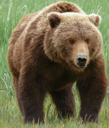

In [ ]:
im = Image.open(dest)
im.to_thumb(128,128)

In [3]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [4]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('content_url'))

In [5]:
fns = get_image_files(path)
fns

(#443) [Path('bears/grizzly/00000002.jpg'),Path('bears/grizzly/00000004.jpg'),Path('bears/grizzly/00000007.jpg'),Path('bears/grizzly/00000005.jpg'),Path('bears/grizzly/00000000.jpg'),Path('bears/grizzly/00000006.jpg'),Path('bears/grizzly/00000009.png'),Path('bears/grizzly/00000001.jpg'),Path('bears/grizzly/00000008.jpg'),Path('bears/grizzly/00000010.jpg')...]

In [6]:
failed = verify_images(fns)
failed

(#17) [Path('bears/grizzly/00000021.jpg'),Path('bears/grizzly/00000057.jpg'),Path('bears/grizzly/00000059.jpg'),Path('bears/grizzly/00000099.jpg'),Path('bears/grizzly/00000143.jpg'),Path('bears/grizzly/00000138.jpg'),Path('bears/grizzly/00000148.jpg'),Path('bears/black/00000039.jpg'),Path('bears/black/00000075.jpg'),Path('bears/teddy/00000029.jpg')...]

In [7]:
failed.map(Path.unlink);

### Sidebar: Getting Help in Jupyter Notebooks

### End sidebar

## From Data to DataLoaders

In [8]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = bears.dataloaders(path)

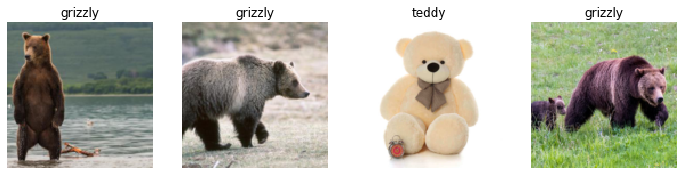

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

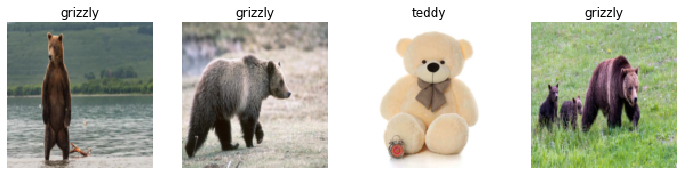

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

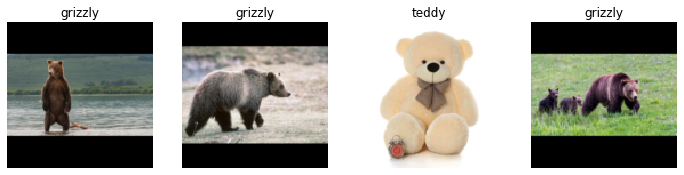

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

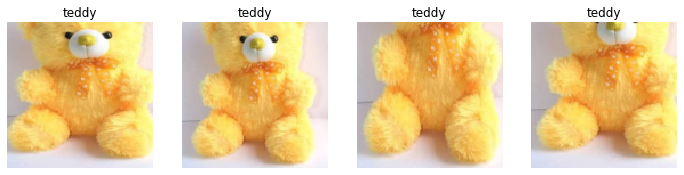

In [ ]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

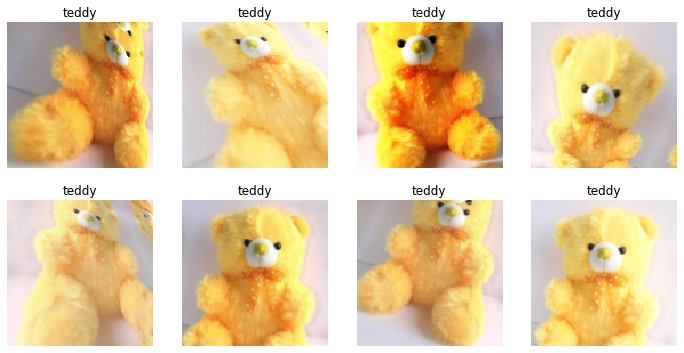

In [ ]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [9]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [10]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.128865,0.172022,0.070588,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.139589,0.090179,0.035294,00:08
1,0.111585,0.152770,0.047059,00:08
2,0.102378,0.128407,0.047059,00:09
3,0.080551,0.093473,0.047059,00:09


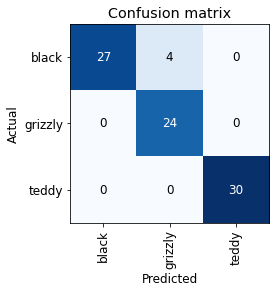

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

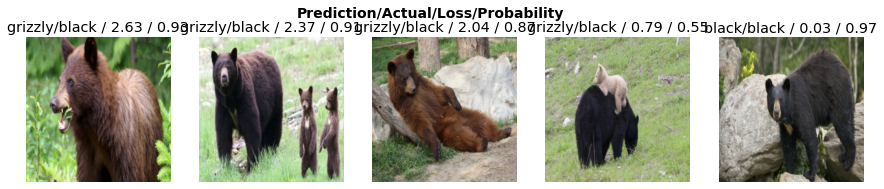

In [12]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [13]:
learn.export()

In [14]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [15]:
learn_inf = load_learner(path/'export.pkl')

In [16]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([1.6544e-05, 9.9998e-01, 1.3896e-07]))

In [17]:
learn_inf.dls.vocab

(#3) ['black','grizzly','teddy']

### Creating a Notebook App from the Model

In [18]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [19]:
img = PILImage.create(btn_upload.data[-1])

In [20]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [21]:
pred,pred_idx,probs = learn_inf.predict(img)

In [22]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

In [23]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [24]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [25]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [26]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [ ]:
#hide
# !pip install voila
# !jupyter serverextension enable voila —sys-prefix

### Deploying your app

## How to Avoid Disaster

### Unforeseen Consequences and Feedback Loops

## Get Writing!

## Questionnaire

1. Provide an example of where the bear classification model might work poorly in production, due to structural or style differences in the training data.
1. Where do text models currently have a major deficiency?
1. What are possible negative societal implications of text generation models?
1. In situations where a model might make mistakes, and those mistakes could be harmful, what is a good alternative to automating a process?
1. What kind of tabular data is deep learning particularly good at?
1. What's a key downside of directly using a deep learning model for recommendation systems?
1. What are the steps of the Drivetrain Approach?
1. How do the steps of the Drivetrain Approach map to a recommendation system?
1. Create an image recognition model using data you curate, and deploy it on the web.
1. What is `DataLoaders`?
1. What four things do we need to tell fastai to create `DataLoaders`?
1. What does the `splitter` parameter to `DataBlock` do?
1. How do we ensure a random split always gives the same validation set?
1. What letters are often used to signify the independent and dependent variables?
1. What's the difference between the crop, pad, and squish resize approaches? When might you choose one over the others?
1. What is data augmentation? Why is it needed?
1. What is the difference between `item_tfms` and `batch_tfms`?
1. What is a confusion matrix?
1. What does `export` save?
1. What is it called when we use a model for getting predictions, instead of training?
1. What are IPython widgets?
1. When might you want to use CPU for deployment? When might GPU be better?
1. What are the downsides of deploying your app to a server, instead of to a client (or edge) device such as a phone or PC?
1. What are three examples of problems that could occur when rolling out a bear warning system in practice?
1. What is "out-of-domain data"?
1. What is "domain shift"?
1. What are the three steps in the deployment process?

### Further Research

1. Consider how the Drivetrain Approach maps to a project or problem you're interested in.
1. When might it be best to avoid certain types of data augmentation?
1. For a project you're interested in applying deep learning to, consider the thought experiment "What would happen if it went really, really well?"
1. Start a blog, and write your first blog post. For instance, write about what you think deep learning might be useful for in a domain you're interested in.

In [3]:
path = Path('ball_types')
types = ["padel", "tennis"]

In [8]:
if not path.exists():
    path.mkdir()
    for typ in types:
        dest=(path/typ)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, typ + "ball")
        download_images(dest, urls=results.attrgot('content_url'))
    


In [9]:
fns = get_image_files(path)
fns

failed = verify_images(fns)
failed

failed.map(Path.unlink);

In [10]:
animals = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

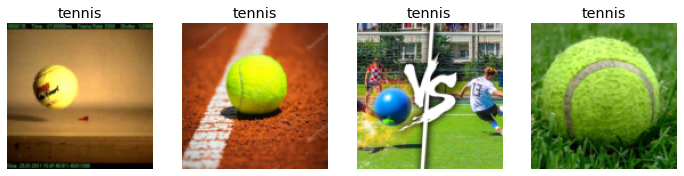

In [11]:
dls = animals.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [39]:
animals = animals.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = animals.dataloaders(path)

In [40]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.056376,2.807094,0.651163,00:03


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.552206,1.318601,0.488372,00:03
1,0.481665,0.207072,0.069767,00:03
2,0.377484,0.063355,0.023256,00:03
3,0.321160,0.038653,0.023256,00:03


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


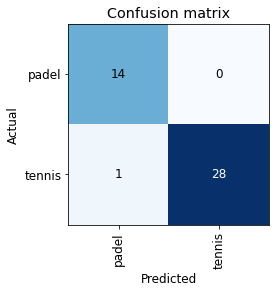

In [41]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

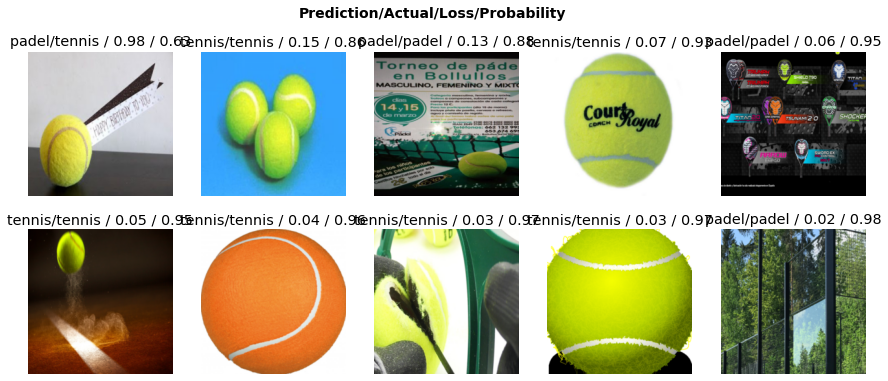

In [42]:
interp.plot_top_losses(10, nrows=2)

In [35]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [38]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,animal in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/animal)

In [43]:
learn.export()

In [44]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [51]:
learn_inf = load_learner(path/'export.pkl')

In [52]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [53]:
img = PILImage.create(btn_upload.data[-1])

In [54]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [55]:
pred,pred_idx,probs = learn_inf.predict(img)

In [56]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: moose; Probability: 0.9990')

In [57]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [58]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)